In [0]:
import os
PLOT_DIR = os.path.join("data", "plots")
CSV_DIR = os.path.join("data", "csv")
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

In [0]:
dbutils.fs.ls("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet")
comments = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments")
submissions = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions")

In [0]:
comments_small = comments.limit(200000)
df = comments_small.toPandas()

In [0]:
df = df.drop(df[df['body']=='[deleted]'].index)
df = df.drop(df[df['body']=='[removed]'].index)

In [0]:
df.body = df.body.astype(str)
print('Comment Metrics')
print(f'Mean: {df.body.map(len).mean():.0f}')
print(f'Min: {df.body.map(len).min():.0f}')
print(f'Max: {df.body.map(len).max():.0f}')
print(f'Std: {df.body.map(len).std():.0f}')

Comment Metrics
Mean: 206
Min: 0
Max: 10331
Std: 563


In [0]:
df.score.describe()

Out[53]: count   181,626.00
mean          7.88
std         109.50
min        -272.00
25%           1.00
50%           2.00
75%           4.00
max      25,596.00
Name: score, dtype: float64

In [0]:
import os
import requests
import json
import numpy as np
import pandas as pd
import zstandard as zstd
import tensorflow as tf
import seaborn as sns
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding, LSTM, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import Constant

# Display Options
pd.options.display.float_format = '{:,.2f}'.format

#Variables
MAX_SEQUENCE_LENGTH = 700
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100

/databricks/python/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


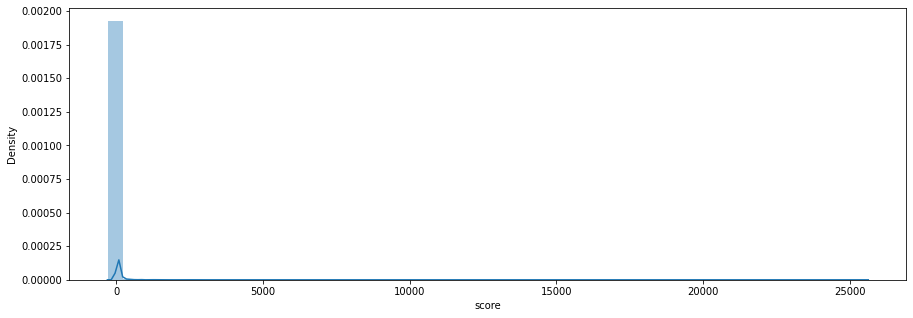

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
sns.distplot(df.score);

In [0]:
!pip install tensorflow

     |▏                               

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 4.9 MB 100.0 MB/s 
     |████████████████████████████████| 781 kB 106.7 MB/s 
     |████████████████████████████████| 232 kB 105.0 MB/s 
     |████████████████████████████████| 177 kB 105.2 MB/s 
     |████████████████████████████████| 155 kB 110.2 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 151 kB 106.5 MB/s 
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-f45d159c-6093-458e-8400-e7c84c725ed7
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.21.5
    Not uninstalling protobuf at /databricks/python3/lib/python3.9/sit

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
<command-2090180743716229> in <cell line: 6>()
      4 import numpy as np
      5 import pandas as pd
----> 6 import zstandard as zstd
      7 import tensorflow as tf
      8 import seaborn as sns

/databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py in import_patch(name, globals, locals, fromlist, level)
    169             # Import the desired module. If you’re seeing this while debugging a failed import,
    170             # look at preceding stack frames for relevant error information.
--> 171             original_result = python_builtin_import(name, globals, locals, fromlist, level)
    172 
    173             is_root_import = thread_local._nest_level == 1

ModuleNotFoundError: No module named 'zstandard'

/databricks/python/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


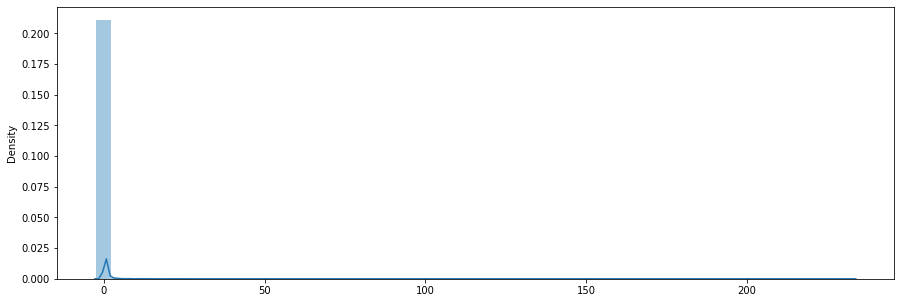

In [0]:
scaler = StandardScaler()
scores = scaler.fit_transform(df.score.values.reshape(-1,1))

plt.figure(figsize=(15, 5))
sns.distplot(scores);

/databricks/python/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


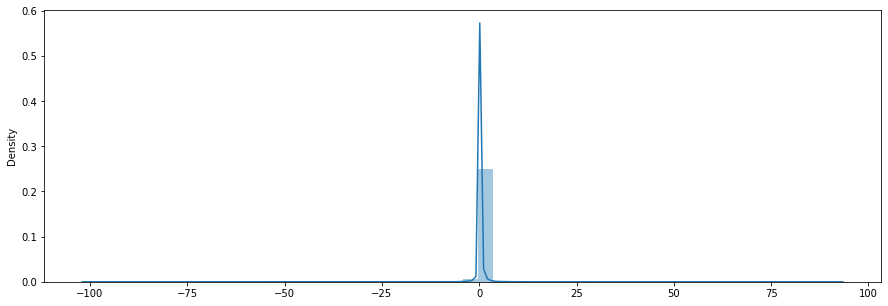

In [0]:
from sklearn.preprocessing import power_transform
scores = power_transform(df.score.values.reshape(-1,1), method='yeo-johnson')

plt.figure(figsize=(15, 5))
sns.distplot(scores);

/databricks/python/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


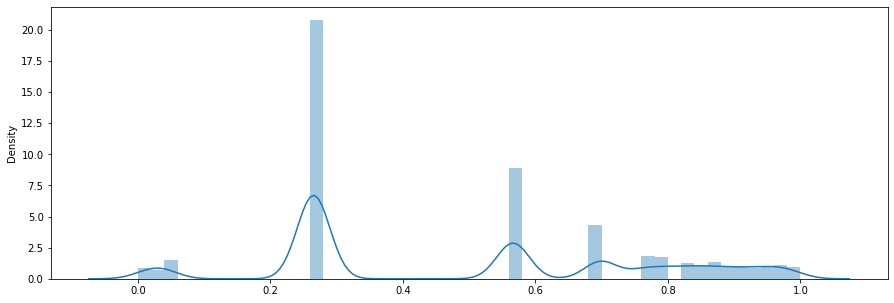

In [0]:
from sklearn.preprocessing import quantile_transform
scores = quantile_transform(df.score.values.reshape(-1,1), n_quantiles=99, random_state=0)
plt.figure(figsize=(15, 5))
sns.distplot(scores);

/databricks/python/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


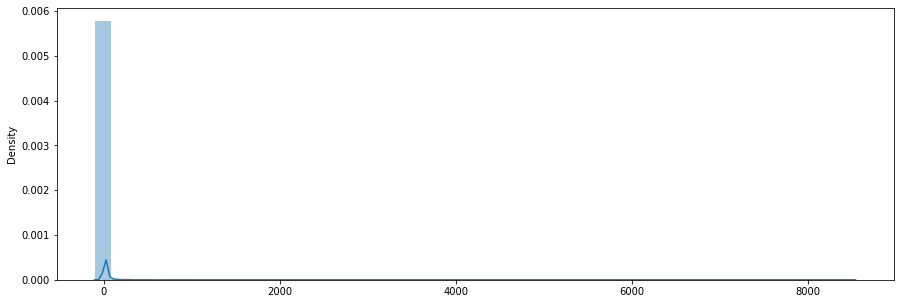

In [0]:
from sklearn.preprocessing import robust_scale
scores = robust_scale(df.score.values.reshape(-1,1))

plt.figure(figsize=(15, 5))
sns.distplot(scores);

In [0]:
df.score.quantile(np.linspace(.04, 1, 24, 0))

Out[60]: 0.04    0.00
0.08    1.00
0.12    1.00
0.16    1.00
0.20    1.00
0.24    1.00
0.28    1.00
0.32    1.00
0.36    1.00
0.40    1.00
0.44    1.00
0.48    2.00
0.52    2.00
0.56    2.00
0.60    2.00
0.64    2.00
0.68    3.00
0.72    3.00
0.76    4.00
0.80    5.00
0.84    7.00
0.88    9.00
0.92   14.00
0.96   27.00
Name: score, dtype: float64

In [0]:
pd.cut(
    df.score, [-10000, 0, 1, 10, 50, 10000],
    labels=['Downvoted', 'No Votes', '2-10 Votes', '11-50 Votes', '50+ Votes']).value_counts()

Out[61]: 2-10 Votes     76112
No Votes       75527
11-50 Votes    15256
Downvoted      10992
50+ Votes       3735
Name: score, dtype: int64

In [0]:
df['score_category'] = pd.cut(
    df.score, [-100000, 0, 1, 10, 50, 100000],
    labels=['Downvoted', 'No Votes', '2-10 Votes', '11-50 Votes', '50+ Votes'])

In [0]:
df.score_category.cat.categories
pd.concat([df.score_category, df.score_category.cat.codes], axis=1).head(10)

,score_category,0
2,2-10 Votes,2
3,2-10 Votes,2
4,No Votes,1
5,2-10 Votes,2
6,2-10 Votes,2
7,11-50 Votes,3
8,No Votes,1
9,11-50 Votes,3
10,11-50 Votes,3
11,2-10 Votes,2


In [0]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
        
        
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df.body)

sequences = tokenizer.texts_to_sequences(df.body)
word_index = tokenizer.word_index
comments = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Prepare Embedding Matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


print(f'Found {len(word_index):,} unique tokens.')

Found 182,653 unique tokens.


In [0]:
pd.Series(word_index).head(10)

Out[65]: the       1
to        2
a         3
and       4
i         5
you       6
of        7
https     8
is        9
it       10
dtype: int64

In [0]:
comments

Out[66]: array([[   0,    0,    0, ...,  312,    1,  164],
       [   0,    0,    0, ...,    8,  152,   18],
       [   0,    0,    0, ..., 6833,  106, 4613],
       ...,
       [   0,    0,    0, ...,    2, 1406,  476],
       [   0,    0,    0, ...,    5,   37,   15],
       [   0,    0,    0, ...,    3,   11,  651]], dtype=int32)

In [0]:
embedding_matrix[word_index['trump']]

Out[30]: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
df.columns

Out[67]: Index(['author', 'author_cakeday', 'author_flair_css_class',
       'author_flair_text', 'body', 'can_gild', 'controversiality',
       'created_utc', 'distinguished', 'edited', 'gilded', 'id',
       'is_submitter', 'link_id', 'parent_id', 'permalink', 'retrieved_on',
       'score', 'stickied', 'subreddit', 'subreddit_id', 'score_category'],
      dtype='object')

In [0]:
df['time_lapse'] = max(df['created_utc'])-df['created_utc']
df['time_lapse']

Out[76]: 2            2131
3            2131
4            2131
5            2131
6            2131
           ...   
199995    4729662
199996    4729662
199997    4729662
199998    4729662
199999    4729662
Name: time_lapse, Length: 181626, dtype: int64

In [0]:
features = df[['created_utc','time_lapse','is_submitter']]
category = df['score_category'].cat.codes

# Scaling Features for Model
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [0]:
comments_train, comments_val, feature_train, feature_val, category_train, category_val = train_test_split(
    comments, features, category, test_size=0.33, random_state=42)

In [0]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False)

In [0]:
comments_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
embedded_sequences = embedding_layer(comments_input)

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(.3)(x)
# comments_prediction = Dense(5, activation='softmax')(x)
comments_output = Dense(128, activation='relu')(x)

feature_input = Input(shape=(3, ))
x = tf.keras.layers.concatenate([comments_output, feature_input])

# We stack a deep densely-connected network on top
x = Dense(250, activation='relu')(x)
x = Dropout(.3)(x)
x = Dense(125, activation='relu')(x)
x = Dropout(.3)(x)

# And finally we add the main logistic regression layer
final_prediction = Dense(5, activation='softmax')(x)

In [0]:
model = Model([comments_input, feature_input], [final_prediction])

model.compile(
    loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit([comments_train, feature_train],
          category_train,
          batch_size=128,
          epochs=6,
          validation_data=([comments_val, feature_val], [category_val]))

Epoch 1/6
145/951 [===>..........................] - ETA: 2:15 - loss: 1.2121 - accu

*** WARNING: max output size exceeded, skipping output. ***

951/951 [==============================] - 204s 214ms/step - loss: 1.1815 - accuracy: 0.4367 - val_loss: 1.1857 - val_accuracy: 0.4342
Out[81]: <keras.callbacks.History at 0x7ff588564af0>

Out[82]: <AxesSubplot:>

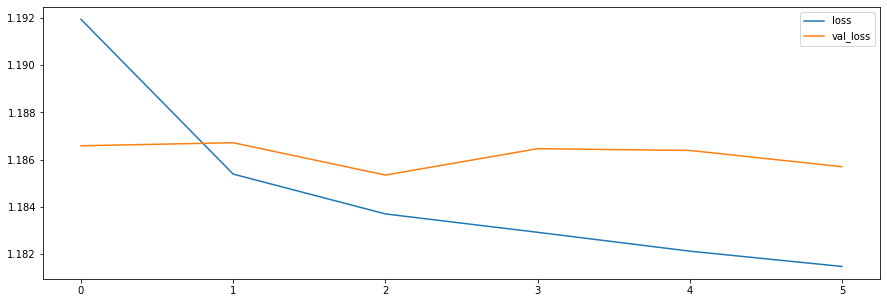

In [0]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot(figsize=(15, 5))

In [0]:
model.save('reddit_score.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
model = load_model('reddit_score.h5')

In [0]:
model = Model([comments_input, feature_input], [final_prediction])

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit([comments_train, feature_train],
          category_train,
          batch_size=128,
          epochs=3,
          validation_data=([comments_val, feature_val], [category_val]))

Epoch 1/3
145/951 [===>..........................] - ETA: 2:23 - loss: 1.1895 - accu

*** WARNING: max output size exceeded, skipping output. ***

951/951 [==============================] - 201s 211ms/step - loss: 1.1811 - accuracy: 0.4379 - val_loss: 1.1858 - val_accuracy: 0.4342
Out[84]: <keras.callbacks.History at 0x7ff5a63f49d0>

Out[85]: <AxesSubplot:>

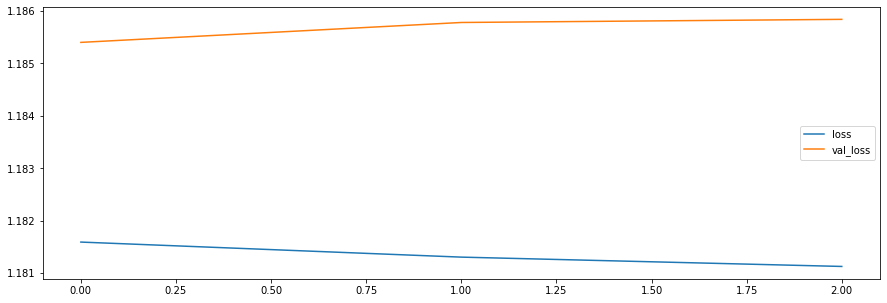

In [0]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot(figsize=(15, 5))

In [0]:
predictions = model.predict([comments_val, feature_val])
prediction_ = np.argmax(predictions, axis = 1)

1874/1874 [==============================] - 26s 14ms/step


In [0]:
confusion_matrix(category_val, prediction_)

Out[87]: array([[    0,   294,  3323,     0,     0],
       [    0,  3515, 21450,     0,     0],
       [    0,  2453, 22507,     0,     0],
       [    0,   240,  4884,     0,     0],
       [    0,    51,  1220,     0,     0]])

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

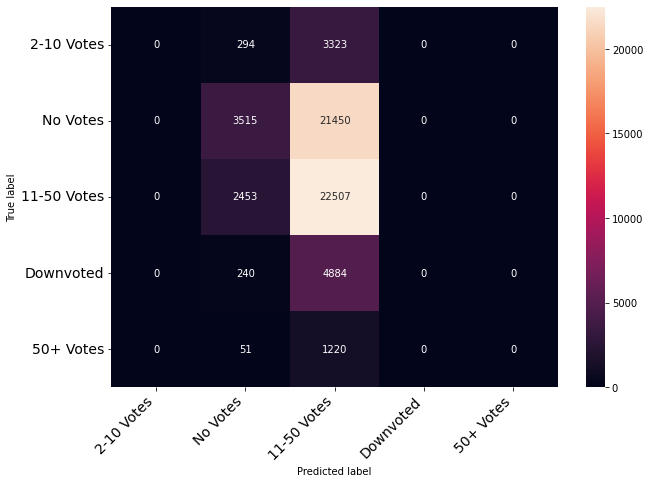

In [0]:
print_confusion_matrix(confusion_matrix(category_val, prediction_), df.score_category.values.unique().tolist());

In [0]:
results = pd.concat([category_val, df.body], axis=1, join='inner').reset_index(drop=True)
results = pd.concat([results, pd.Series(prediction_)], axis=1)
results.columns = ['Actual', 'Comment', 'Prediction']

In [0]:
results.head()

,Actual,Comment,Prediction
0,1,"On my S21+ it works like it should, instantly,...",2
1,4,Are you sure he’s not trying to scare you off?...,2
2,2,Fair enough I don't mind them that much,1
3,3,Thats my thought!\n\nLike possibly you could g...,2
4,1,"Recommended Subreddits: r/baberotica, r/nsfwg...",2


In [0]:
results[(results.Actual == 4) & (results.Prediction == 0) ].Comment.values

Out[92]: array([], dtype=object)